# Environment switch

Single-cell RNA sequencing was performed after mice were housed in one of three different olfactory environments.

In [1]:
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import numpy_groupies as npg
import pandas as pd
import scanpy as sc
from scipy import stats
from sklearn.preprocessing import LabelEncoder

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from osn.nmf.dprime import get_dprime
from osn.olfr import olfr, clf
from osn.preprocess import get_data_folders
from osn.viz import viz

In [3]:
sns.set_context("notebook")
sns.set(font_scale=1.5, style="ticks", palette="tab10")

# load adata and look at OSNs from control (DPG) mice

In [4]:
data_fold = get_data_folders()
ad_fn = data_fold.processed / "env_switch_norm.h5ad"

DPG = "DPG30m"

eA = "envA"
eB = "envB"
HC = "home-cage"
ENVS = [HC, eA, eB]
n_env = len(ENVS)
ES_SCORE = "ES score"

SOURCE_THRESH = 4

In [5]:
adata = sc.read(ad_fn)
print(adata)

AnnData object with n_obs × n_vars = 94569 × 31756
    obs: 'top_Olfr', 'orig_ident', 'source', 'env', 'odor', 'time', 'ES_score', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_high_expr', 'log1p_total_counts_high_expr', 'pct_counts_high_expr', 'good_total_counts'
    var: 'mito', 'ribo', 'high_expr', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'X_nmf'


In [6]:
df_OR, has_OR = olfr.get_OR_info(adata)

# number of OSNs for each env for each odor
display(df_OR.groupby(["env"]).odor.value_counts().unstack())

df_dpg = df_OR[df_OR.odor == DPG].copy()

odor,ACE2h,DPG2h,DPG30m
env,,,
envA,11184,10092,10435
envB,12650,7346,11304
home-cage,11674,9489,10395


## look at correlation of ES scores across mice/envs 

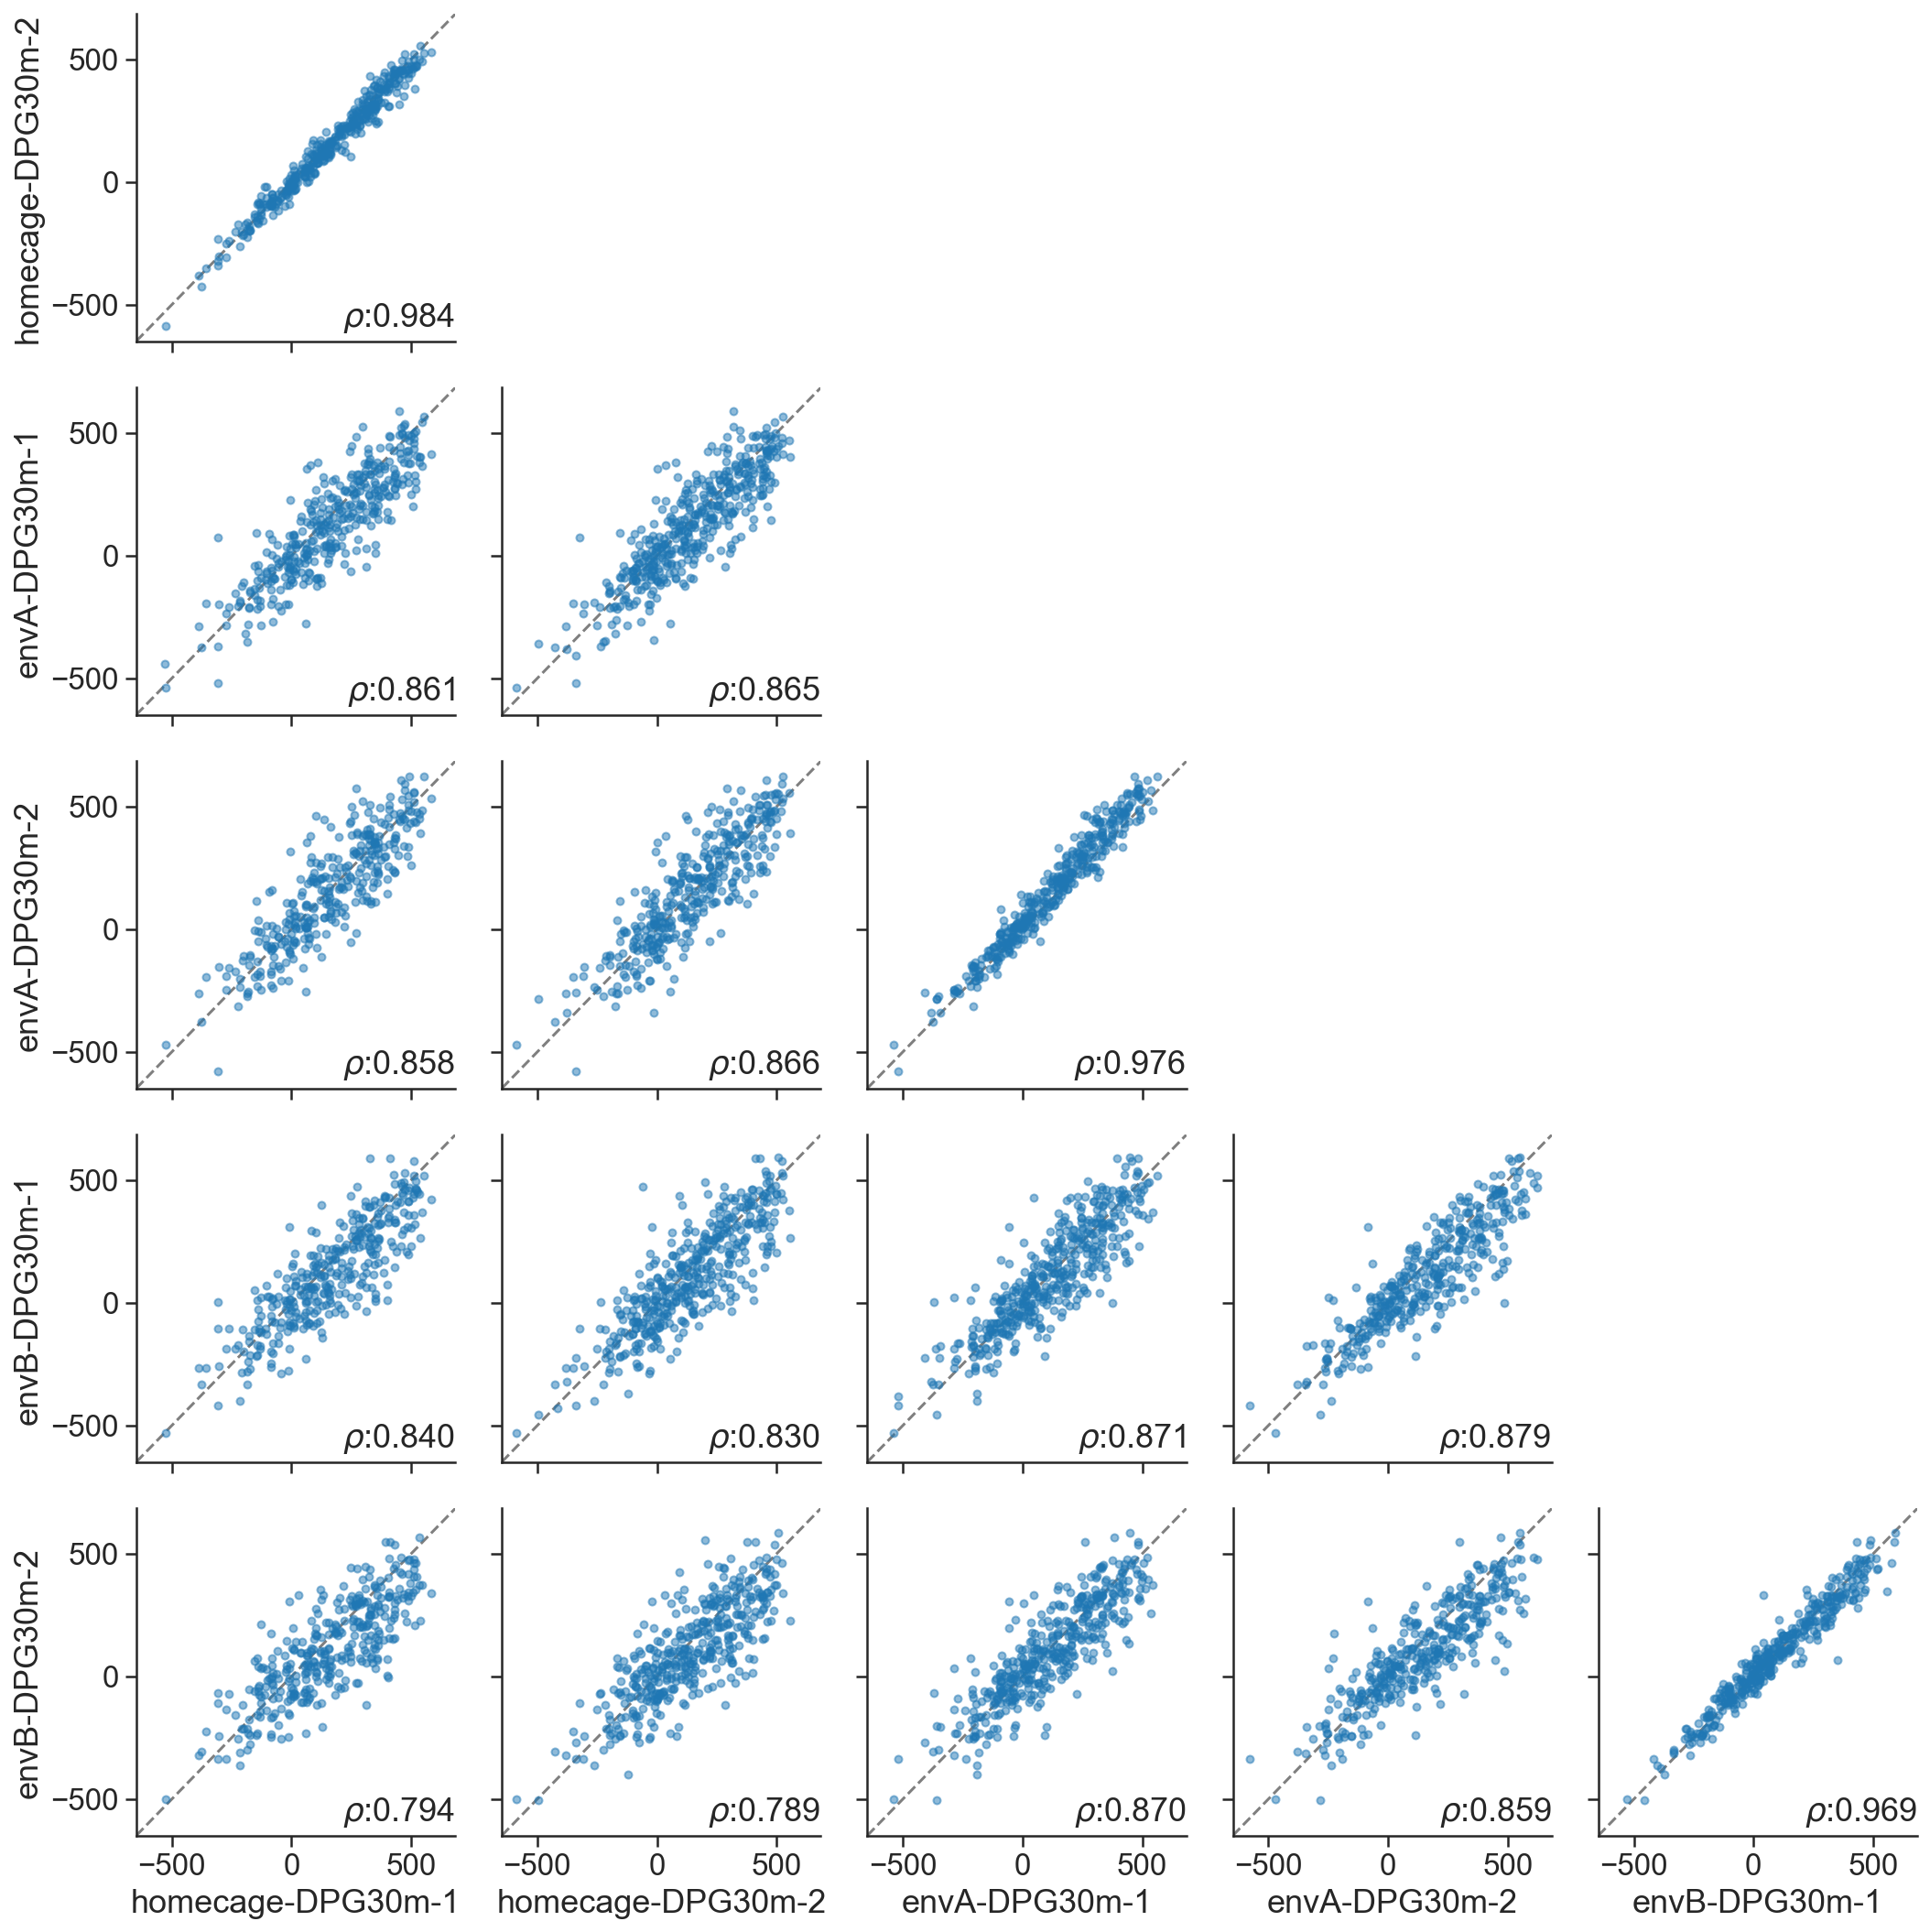

In [7]:
mice, mouse_dict, _ = olfr.make_combo_df(df_dpg)
fig = viz.plot_combos(mice, mouse_dict);

<AxesSubplot:>

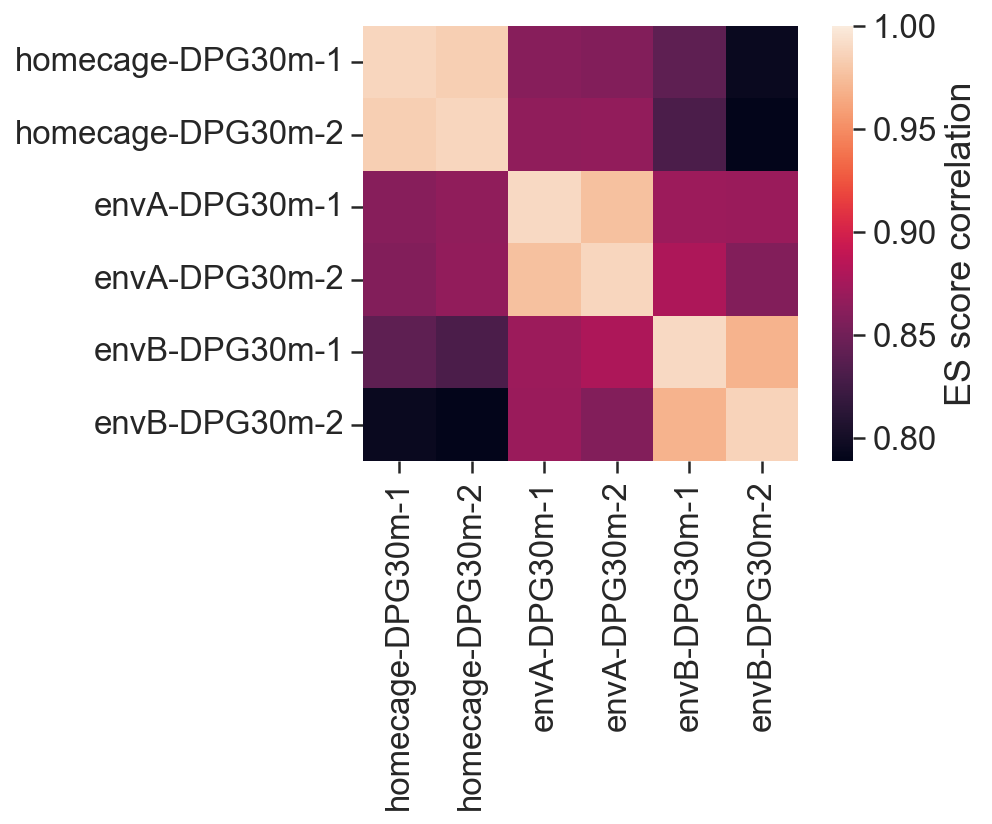

In [8]:
# make as heatmap
n_mice = len(mice)
mat = np.zeros((n_mice, n_mice))
df_corr = pd.DataFrame(mat, index=mice, columns=mice)
for (m2, m1), vals in mouse_dict.items():
    _df = vals["ES_score"].unstack()
    df_corr.loc[m1][m2] = stats.spearmanr(_df[m1], _df[m2])[0]
df_corr = df_corr + df_corr.T

# add bootstrapped on-diagonal
for mouse in df_corr.index:
    df_mouse = df_dpg[df_dpg.orig_ident == mouse]
    _, has_enough = olfr.filter_OR_source(df_mouse, SOURCE_THRESH)
    df_mouse_keep = df_mouse[has_enough]

    or_labels = LabelEncoder().fit_transform(df_mouse_keep.top_Olfr)
    g1_idx, tril_idx = olfr.get_boot_idx(or_labels)
    ess = df_mouse_keep.ES_score.values
    # mean ES score for each OR, where, across restarts, the ES scores are sampled with replacement for each OR
    g1_mean = npg.aggregate(or_labels[g1_idx[:, 0]], ess[g1_idx], func="mean", axis=0)
    # pairwise correlation across restarts
    df_corr[mouse].loc[mouse] = np.mean(stats.spearmanr(g1_mean).correlation[tril_idx])

names = df_corr.index.map(lambda l: l.replace("baseline", "homecage"))
df_corr.index = names
df_corr.columns = names
sns.heatmap(df_corr, vmax=1, cbar_kws={"label": "ES score correlation"}, square=True)

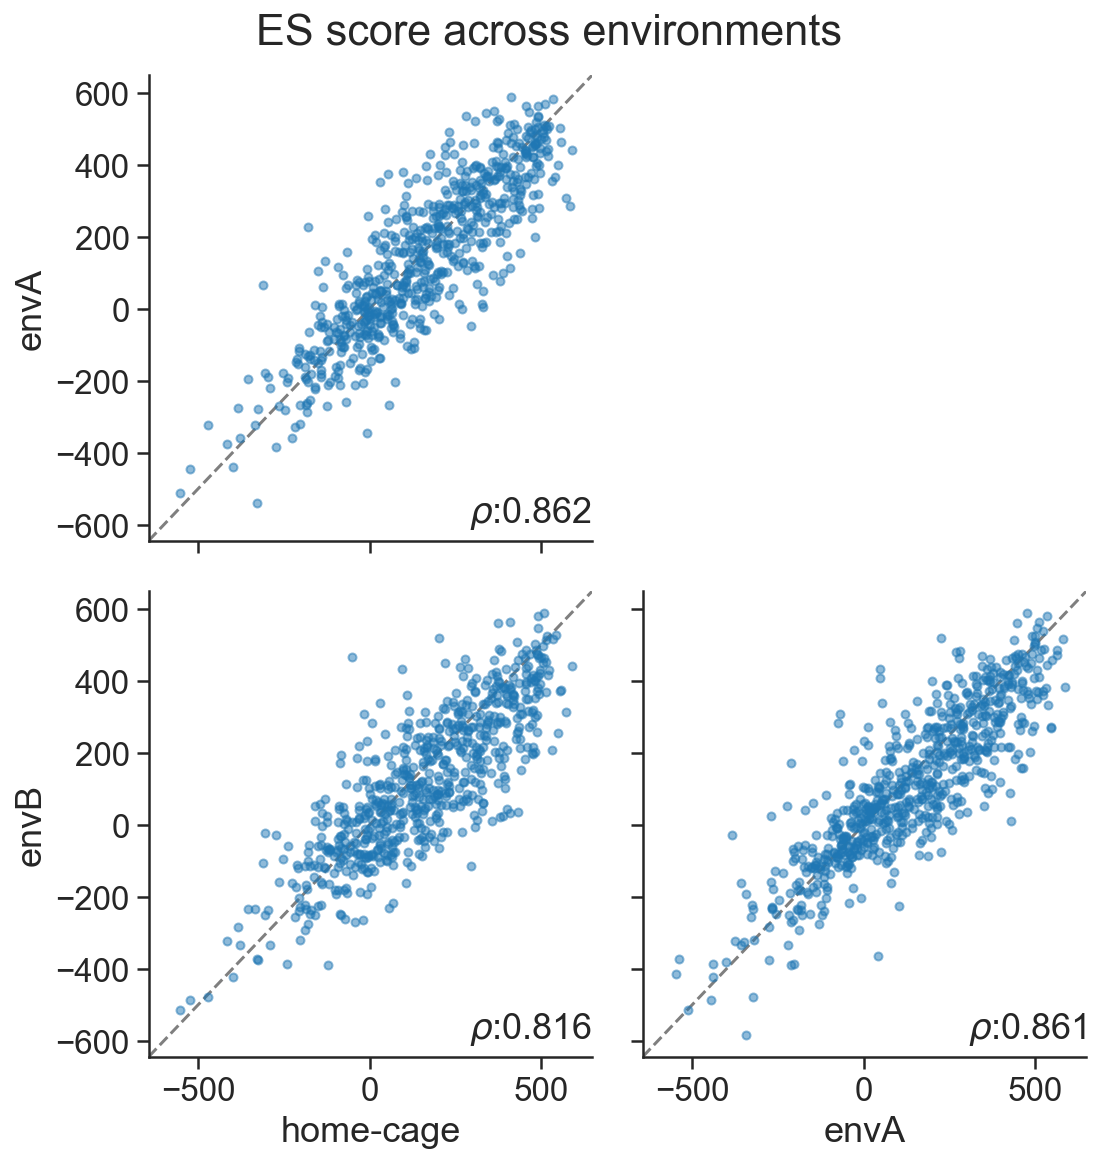

In [9]:
# The cells from the two replicates for each environment were combined
# plot the ES score for each OSN subtype in each pair of environments
env, env_dict, _ = olfr.make_combo_df(df_dpg, col="env", uq=ENVS)
fig, _ = viz.plot_combos(env, env_dict, fs=(8,8));
fig.suptitle("ES score across environments", y=1.02);

# Find ORs with significant changes 
Using the d-prime metric, calculated empirically for the ES score changes across envs for OSNs from each OSN subtype

In [10]:
# between-env
dprime_combo_dict = get_dprime(df_dpg, ENVS)
# within-env
dprime_within_combo_dict = get_dprime(df_dpg, ENVS, within=True)

Using 664 ORs for combo: ('home-cage', 'envA')
39.307 % of ORs have significant d-prime values
Using 662 ORs for combo: ('home-cage', 'envB')
50.000 % of ORs have significant d-prime values
Using 699 ORs for combo: ('envA', 'envB')
39.485 % of ORs have significant d-prime values
Using 375 ORs for combo: ('baseline-DPG30m-1', 'baseline-DPG30m-2')
0.000 % of ORs have significant d-prime values
Using 387 ORs for combo: ('envA-DPG30m-1', 'envA-DPG30m-2')
5.168 % of ORs have significant d-prime values
Using 399 ORs for combo: ('envB-DPG30m-1', 'envB-DPG30m-2')
3.509 % of ORs have significant d-prime values


Text(0, 0.5, '% of ORs with sig. ES score changes')

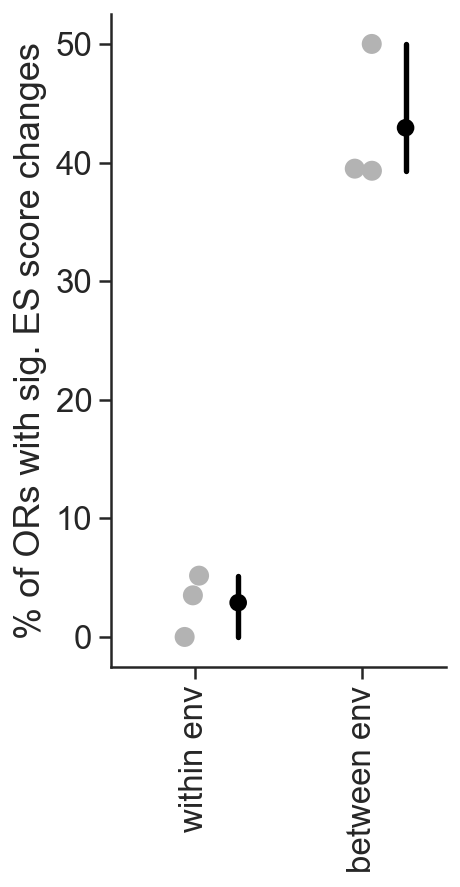

In [11]:
between = [np.mean(vals['p'].sig) * 100 for vals in dprime_combo_dict.values()]
within = [np.mean(vals['p'].sig) * 100 for vals in dprime_within_combo_dict.values()]
df_mean_sig = pd.DataFrame([within, between], index=['within env', 'between env']).T.melt()

fig, ax = plt.subplots(figsize=(3, 6))
np.random.seed(1234)
sns.pointplot(
    data=df_mean_sig,
    x="variable",
    y="value",
    s=10,
    jitter=0.1,
    join=False,
    zorder=10,
    color="k",
)
viz.offest_pointplot(ax)
sns.stripplot(
    data=df_mean_sig, x="variable", y="value", s=10, jitter=0.1, color="0.7", zorder=-5
)

sns.despine()
plt.xticks(rotation=90)
ax.set_xlabel(None)
ax.set_ylabel("% of ORs with sig. ES score changes")

('home-cage', 'envA')


pos,False,True
sig,,
False,211,192
True,154,107


('home-cage', 'envB')


pos,False,True
sig,,
False,183,148
True,227,104


('envA', 'envB')


pos,False,True
sig,,
False,231,192
True,173,103


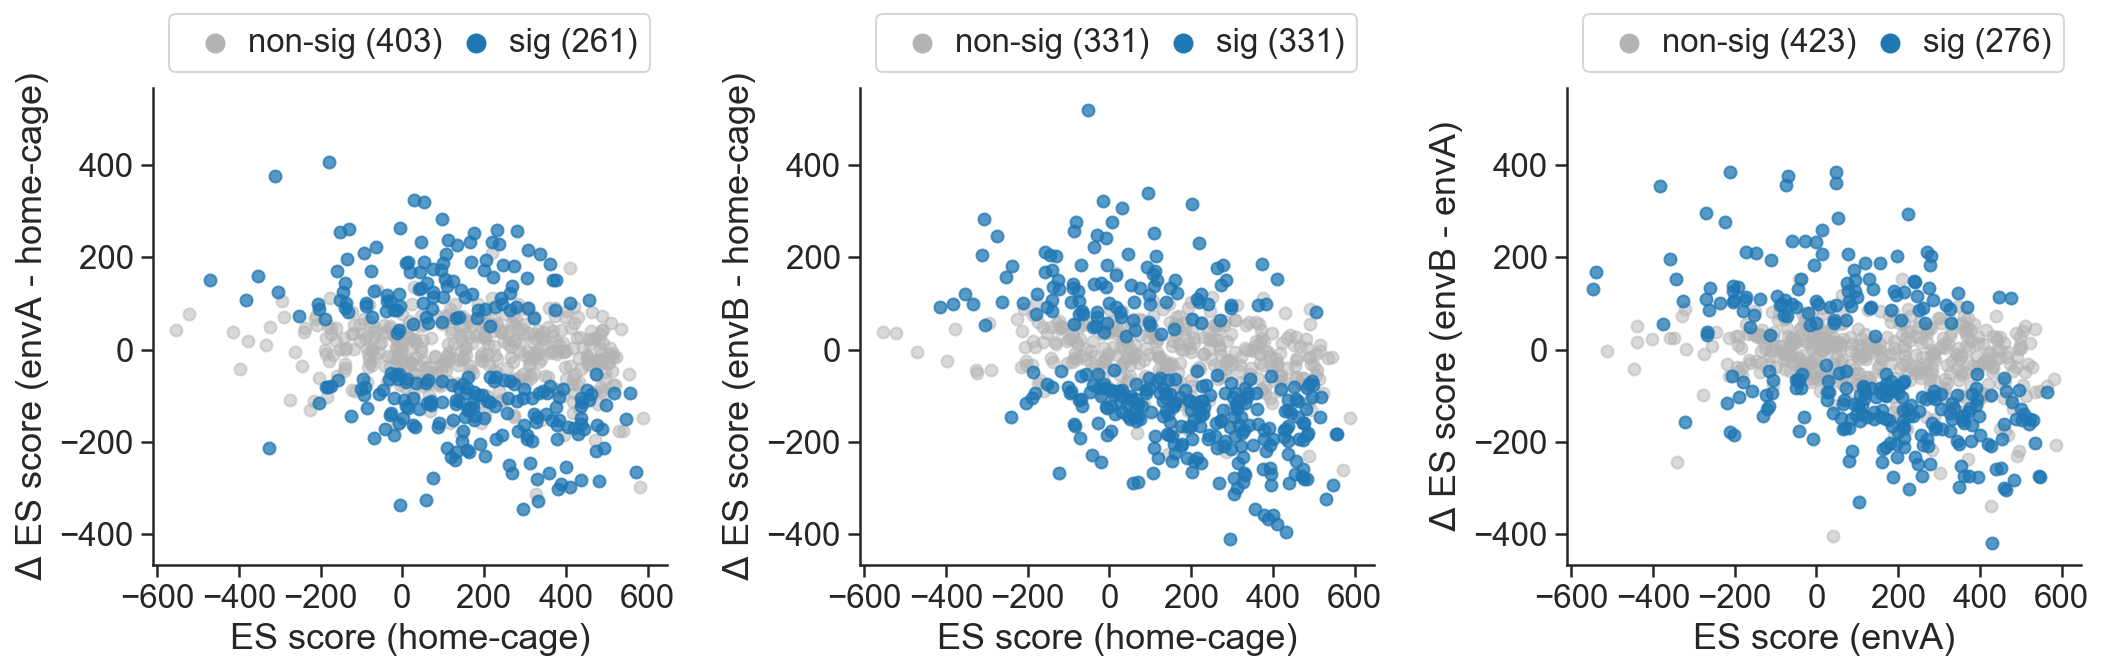

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
for ax, (combo, vals) in zip(axes, dprime_combo_dict.items()):
    ax.yaxis.set_tick_params(labelleft=True)
    e1, e2 = combo
    df_dpg_mean = vals["df"].groupby(["top_Olfr", "env"]).mean()
    df_dpg_act_mean = df_dpg_mean["ES_score"].unstack()
    x = df_dpg_act_mean[e1]
    _df = vals["p"]
    print(combo)
    display(pd.crosstab(_df.sig, _df.pos))
    es_diff = _df.delta_ES_score
    is_sig = _df["sig"]
    ax.scatter(x[~is_sig], es_diff[~is_sig], alpha=0.5, color="0.7", label=f"non-sig ({(~is_sig).sum()})")
    ax.scatter(x[is_sig], es_diff[is_sig], alpha=0.75, label=f"sig ({is_sig.sum()})")
    ax.set_xlabel(f"{ES_SCORE} ({e1})")
    ax.set_ylabel(rf"$\Delta$ {ES_SCORE} ({e2} - {e1})")
    leg = ax.legend(markerscale=1.5, ncol=2, bbox_to_anchor=(0.5, 1), loc="lower center", columnspacing=0, handletextpad=0)
    for lh in leg.legendHandles:
        lh.set_alpha(1)
    ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
    ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(200))
sns.despine()
fig.tight_layout()

# Decoding of environment via ES score
* using a minimum-distance classification procedure with pseudopulations of OSN subtypes

In [13]:
df_melt = clf.es_score_decoding(df_dpg, NBOOT=1000, NRAND=1000)

Using 477 ORs found in at least 6 cells in all 3 envs.
Subsampling 6 cells per OR for each of 1000 restarts.
Performing classification, subsampling (1–100) ORs 1000 times for each restart.


shuffled: 100%|█████████████████████████████████████████████████████| 40/40 [00:20<00:00,  1.98it/s]


(<Figure size 432x432 with 1 Axes>,
 <AxesSubplot:xlabel='# of ORs', ylabel='Environment classification accuracy (%)'>)

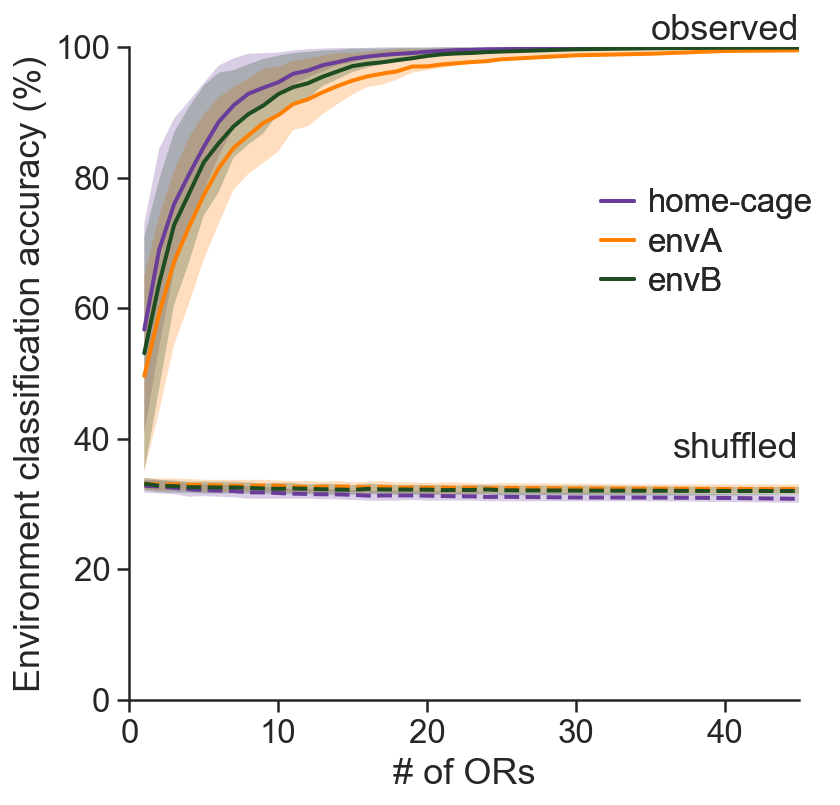

In [14]:
viz.plot_es_score_decoding(df_melt, ENVS)